In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np
import datetime
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from keras.optimizers import Adam
import tensorflow_addons as tfa
import tensorflow as tf


original_start = datetime.datetime.now()
start = datetime.datetime.now()

## In this notebook, we will use the AdamW opitimizer to see if it can give us strong results without overfitting
## This optimizer performs weight decay after controlling the parameter-wise step size

In [3]:
##Setting our directories

train_dir = 'chest_xray/train'
validation_dir = 'chest_xray/val/'
test_dir = 'chest_xray/test/'

In [124]:
# All images will be rescaled by 1./255
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
        # Target directory
        train_dir,
        # Resizing images
        target_size=(150, 150),
        batch_size= 500,
        # We need binary labels
        class_mode='binary')

val_data = datagen.flow_from_directory(validation_dir, 
                                           target_size=(150, 150), 
                                           batch_size=16,
                                           class_mode='binary',)
test_data = datagen.flow_from_directory(test_dir, 
                                           target_size=(150, 150), 
                                           batch_size=50,
                                           class_mode='binary', shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
#split images and labels
train_images, train_labels = next(train_data)
val_images, val_labels = next(val_data)
test_images, test_labels = next(test_data)

In [12]:
## Data Augmentation

augm_datagen = ImageDataGenerator(rescale = 1./255,
                                          rotation_range = 30,
                                          horizontal_flip = True,
                                          brightness_range = [0.8, 1.2],
                                          zoom_range = 0.2)
train_aug = augm_datagen.flow_from_directory(train_dir,
                              target_size=(150, 150),
                              batch_size=16,
                              class_mode='binary')

Found 5216 images belonging to 2 classes.


In [13]:
trainaug_images, trainaug_labels = next(train_aug)

## Model 1

In [24]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(96, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(288, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(864, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))

##Learning rate

step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
        [1407*20, 1407*30], [1e-3, 1e-4, 1e-5])

## Weight decay

wd = lambda: 1e-1 * schedule(step)

model.compile(loss='binary_crossentropy',
              optimizer=tfa.optimizers.AdamW(amsgrad = True, learning_rate=schedule, weight_decay=wd),
              metrics=['accuracy', 'Recall'])

##Using class weight to address class imbalance

results = model.fit(train_aug,
          epochs = 5,
          validation_data=val_data,  class_weight= {0:3 , 1:1})

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
326/326 [==============================] - ETA: 0s - loss: 1.0542 - accuracy: 0.4893 - recall: 0.4377WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7ff3284c73b0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_V

In [25]:
results_train = model.evaluate(train_data)
results_test = model.evaluate(test_data)
print(results_train, results_test)

13/13 [==============================] - 7s 519ms/step - loss: 0.7113 - accuracy: 0.7516 - recall: 0.9513
[0.19218550622463226, 0.9213957190513611, 0.8954838514328003] [0.7113169431686401, 0.7516025900840759, 0.9512820243835449]


## Very good testing recall, but the testing accuracy is unacceptable

## 

## Model 2

In [33]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))

##Learning Rate

step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
        [1407*20, 1407*30], [1e-3, 1e-4, 1e-5])

##Weight decay

wd = lambda: 1e-1 * schedule(step)

model.compile(loss='binary_crossentropy',
              optimizer=tfa.optimizers.AdamW(amsgrad = True, learning_rate=schedule, weight_decay=wd),
              metrics=['accuracy', 'Recall'])

##Using class weight to address class imbalance

results = model.fit(train_aug,
          epochs = 15,
          validation_data=val_data,  class_weight= {0:3 , 1:1})


Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
326/326 [==============================] - ETA: 0s - loss: 0.9149 - accuracy: 0.6210 - recall: 0.5603WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7ff0584498c0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_

In [34]:
results_train = model.evaluate(train_data)
results_test = model.evaluate(test_data)
print(results_train, results_test)

13/13 [==============================] - 8s 642ms/step - loss: 0.3232 - accuracy: 0.9054 - recall: 0.9744
[0.1291036605834961, 0.949386477470398, 0.9476128816604614] [0.3231872320175171, 0.9054487347602844, 0.9743589758872986]


## Very good overall results, but this model is showing classic signs of overfitting
## Validation accuracy and validation recall fluctuate wildly

## 

## Model 3

## Let's address overfitting by simplifying our layers

In [35]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(96, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(364, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

## Learning rate

step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
        [1407*20, 1407*30], [1e-3, 1e-4, 1e-5])

## Weight Decay

wd = lambda: 1e-1 * schedule(step)

model.compile(loss='binary_crossentropy',
              optimizer=tfa.optimizers.AdamW(amsgrad = True, learning_rate=schedule, weight_decay=wd),
              metrics=['accuracy', 'Recall'])

##Using class weight to address class imbalance

results = model.fit(train_aug,
          epochs = 20,
          validation_data=val_data,  class_weight= {0:3 , 1:1})

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
326/326 [==============================] - ETA: 0s - loss: 0.7422 - accuracy: 0.7592 - recall: 0.7443WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7ff3aaddd290> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_

In [36]:
results_train = model.evaluate(train_data)
results_test = model.evaluate(test_data)
print(results_train, results_test)

13/13 [==============================] - 7s 527ms/step - loss: 0.2414 - accuracy: 0.9327 - recall: 0.9718
[0.14475786685943604, 0.9438266754150391, 0.9287741780281067] [0.2414158135652542, 0.932692289352417, 0.971794843673706]


In [173]:
def visualize_training_results(results):
  history = results.history
  epochs = range(1, len(history['loss']) + 1)

  plt.figure(figsize=(25,8))
  plt.subplot(131)
  plt.plot(epochs, history['loss'], 'y', label='Training loss')
  plt.plot(epochs, history['val_loss'], 'b', label='Validation loss')
  plt.title('Training And Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(132)
  plt.plot(epochs, history['accuracy'], 'y', label='Training acc')
  plt.plot(epochs, history['val_accuracy'], 'b', label='Validation acc')
  plt.title('Training And Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(133)
  plt.plot(epochs, history['recall'], 'y', label='Training Recall')
  plt.plot(epochs, history['val_recall'], 'b', label='Validation Recall')
  plt.title('Training And Validation Recall')
  plt.xlabel('Epochs')
  plt.ylabel('Recall')
  plt.legend()
    
  plt.savefig('adamw.png')

  

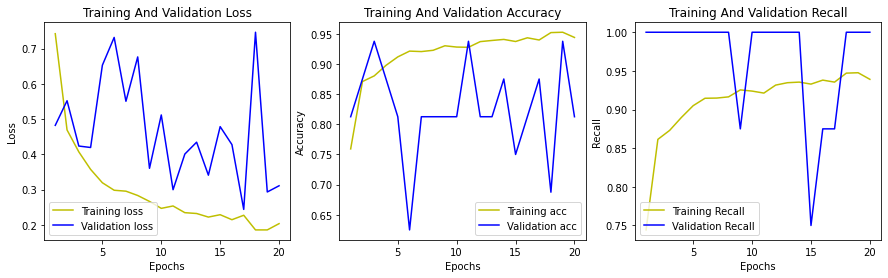

In [39]:
visualize_training_results(results)

## Excellent results again, but still showing clear signs of overfitting
## Validation loss, validation accuracy, and validation recall all fluctuate too much

## 

## Model 4 

## Let's try to run an even simpler model to finally address overfitting

In [44]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(96, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

##Learning rate

step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
        [1407*20, 1407*30], [1e-3, 1e-4, 1e-5])

##Weight decay

wd = lambda: 1e-1 * schedule(step)

model.compile(loss='binary_crossentropy',
              optimizer=tfa.optimizers.AdamW(amsgrad = True, learning_rate=schedule, weight_decay=wd),
              metrics=['accuracy', 'Recall'])
##Using class weight to address class imbalance

results = model.fit(train_aug,
          epochs = 15,
          validation_data=val_data,  class_weight= {0:3 , 1:1})

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
326/326 [==============================] - ETA: 0s - loss: 0.7021 - accuracy: 0.7442 - recall: 0.7182WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7ff0584e25f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_

In [47]:
results_train = model.evaluate(train_data)
results_test = model.evaluate(test_data)
print(results_train, results_test)

13/13 [==============================] - 6s 465ms/step - loss: 0.2335 - accuracy: 0.9151 - recall: 0.9385
[0.22484280169010162, 0.918136477470398, 0.8941935300827026] [0.233531191945076, 0.9150640964508057, 0.9384615421295166]


## A slight decrease in both recall and accuracy, but it appears to show less overfitting

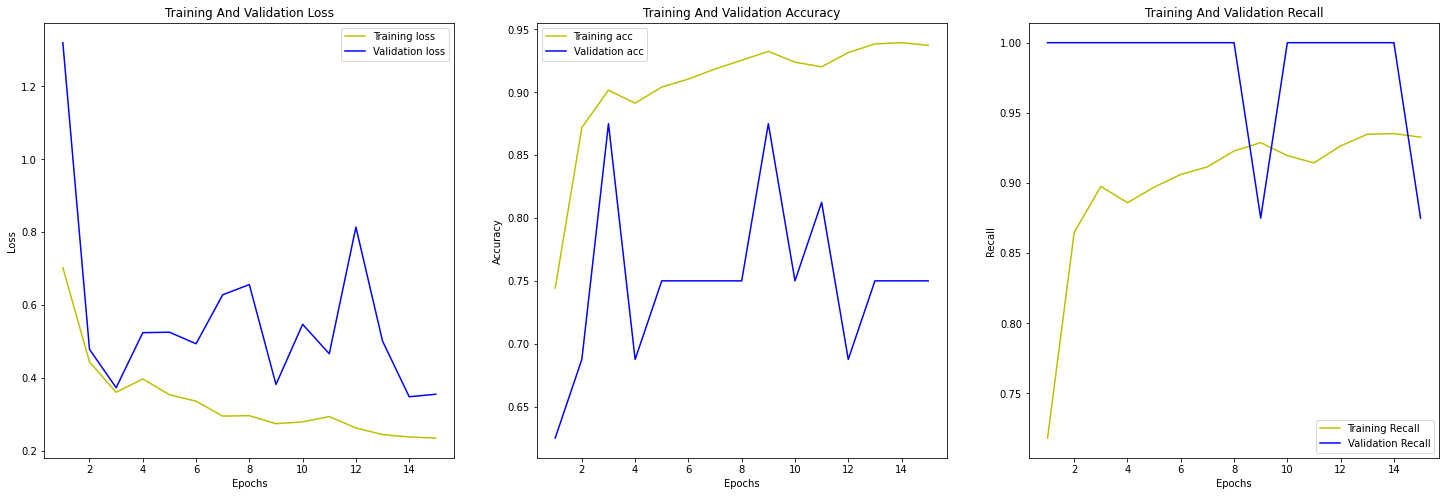

In [174]:
visualize_training_results(results)





## Much better results. Although far from perfect, this model deals with overfitting better than any of the 3 previous models.

## I will keep the model as it has the best balance of very high accuracy and recall, while best controlling for overfitting

## It appears the key here to addressing overfitting was simplifying the model.

In [125]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 18, 18, 96)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 31104)           

In [126]:
model.evaluate(test_data)

13/13 [==============================] - 5s 389ms/step - loss: 0.2335 - accuracy: 0.9151 - recall: 0.9385


[0.2335311472415924, 0.9150640964508057, 0.9384615421295166]

In [127]:
prediction = model.predict_classes(test_data)

In [128]:
prediction

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [129]:
test_data.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [130]:
prediction

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [131]:
prediction.size

624

In [132]:
from sklearn.metrics import confusion_matrix

In [133]:
cm = confusion_matrix(test_data.classes, prediction)
cm

array([[205,  29],
       [ 24, 366]])

In [140]:
## Confusion matrix function

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[205  29]
 [ 24 366]]


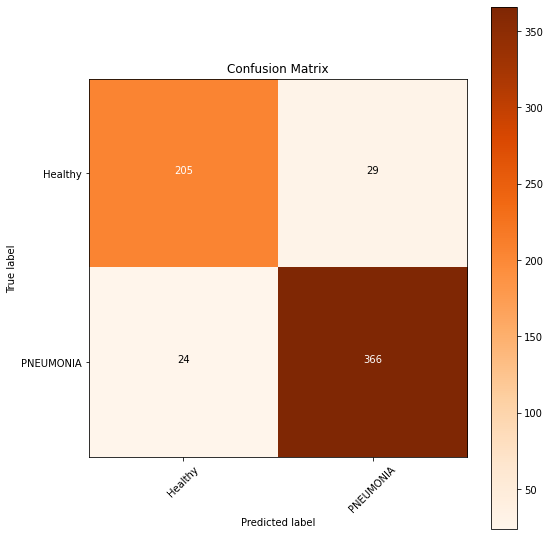

In [155]:
## Confusion matrix

plt.figure(figsize = (8,8))
plot_confusion_matrix(confusion_matrix(test_data.classes, prediction), classes=['Healthy', 'PNEUMONIA'], normalize=False,
                      title='Confusion Matrix',)
plt.savefig('confusion_matrix.png')

In [144]:
n = 0
false_indices = []
for i in range(0,624):

  if test_data.classes[i] != prediction[i]:
    false_indices.append(n)
  n += 1
len(false_indices)

53

In [145]:
FP_indices = []
FN_indices = []
for n in false_indices:
  if (prediction[n] == [1]) and (test_data.classes[n] == 0):
    FP_indices.append(n)
  elif (prediction[n] == [0]) and (test_data.classes[1] == 0):
    FN_indices.append(n)

In [146]:
print(len(FP_indices))
print(len(FN_indices))

29
24


In [147]:
test_data = datagen.flow_from_directory(test_dir, 
                                           target_size=(150, 150), 
                                           batch_size=624,
                                           class_mode='binary',
                                        shuffle = False)

Found 624 images belonging to 2 classes.


In [148]:
images_test, labels_test = next(test_data)

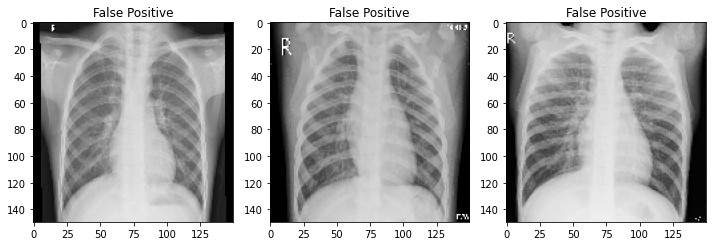

In [175]:
i = 0
plt.figure(figsize = (10, 10))
for n in FP_indices[:3]:
  i += 1
  plt.subplot(1,3,i)
  plt.imshow(images_test[n])
  plt.tight_layout()
  plt.title('False Positive')
plt.savefig('false_positives.png')

## The false positives appear to be in fact positive! The images have a high amount of opacity. Also, the fact that they are so bright is contributing to the misclassification

## In other words, it seems like there are issues with the images themselves moreso than issues with our model.

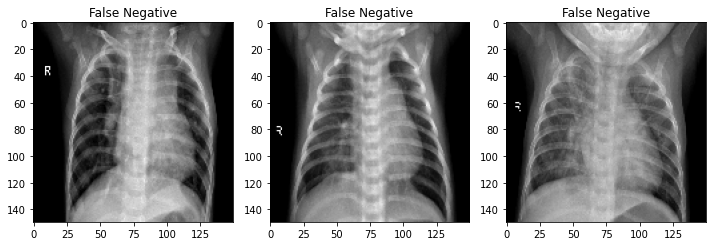

In [176]:
i = 0
plt.figure(figsize = (10, 10))
for n in FN_indices[:3]:
  i += 1
  plt.subplot(1,3,i)
  plt.imshow(images_test[n])
  plt.tight_layout()
  plt.title('False Negative')
plt.savefig('false_negative.png')

## These false negatives appear to be negative for pneumonia. They have a high amount of transparency. Also, these images are quite dark, contributing to the misclassification.

## Once again, it seems like an issue with the X-ray images themselves than with our model.